In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,mean, count
from pyspark.sql.types import *

In [2]:
data_path = "./data/"
review_file_mapping = {"giftcards":"amazon_reviews_us_Gift_Card_v1_00.tsv",
                       "personal_care_appliances": "amazon_reviews_us_Personal_Care_Appliances_v1_00.tsv",
                       "mobile_electronics": "amazon_reviews_us_Mobile_Electronics_v1_00.tsv",
                       "major_appliances": "amazon_reviews_us_Major_Appliances_v1_00.tsv",
                       "digital_video_games": "amazon_reviews_us_Digital_Video_Games_v1_00.tsv",
                       "digital_software": "amazon_reviews_us_Digital_Software_v1_00.tsv"}

spark = SparkSession.builder \
    .appName("Analyse Reviews") \
    .getOrCreate()

In [3]:
schema = StructType([
     StructField("marketplace", StringType(), True),
    StructField("customer_id", LongType(), True),
    StructField("review_id", StringType(), True),
    StructField("product_id", StringType(), True),
    StructField("product_parent", StringType(), True),
    StructField("product_title", StringType(), True),
    StructField("product_category", StringType(), True),
    StructField("star_rating", LongType(), True),
    StructField("helpful_votes", LongType(), True),
    StructField("total_votes", LongType(), True),
    StructField("vine", StringType(), True),
    StructField("verified_purchase", StringType(), True),
    StructField("review_headline", StringType(), True),
    StructField("review_body", StringType(), True),
    StructField("review_date", StringType(), True)
])
df = spark.createDataFrame([], schema)
for file in review_file_mapping:
    file_df = spark.read.csv(data_path + review_file_mapping[file], schema=schema, sep="\t", header=True).sample(fraction=0.01)
    df = df.union(file_df)
#file_path = data_path + review_file_mapping["giftcards"]
#df = spark.read.csv(file_path, schema=schema, sep="\t", header=True)
df.count()

6911

In [4]:
from pyspark.sql.functions import col, lower, when, regexp_replace, to_date, coalesce, lit, mean, count

def preprocess(df):
    def is_ascii(column):
       return col(column).rlike("^[\\x00-\\x7F]*$")

    # Validate integer fields
    df = df.filter(col('customer_id').isNotNull() & col('customer_id').cast("long").isNotNull())
    df = df.filter(col('star_rating').isNotNull() & (col('star_rating') >= 1) & (col('star_rating') <= 5))
    df = df.filter(col('helpful_votes').isNotNull() & col('helpful_votes').cast("long").isNotNull())
    df = df.filter(col('total_votes').isNotNull() & col('total_votes').cast("long").isNotNull())
    # Validate string fields
    df = df.filter(col('product_id').isNotNull() & (col('product_id') != ""))
    df = df.filter(col('marketplace').isNotNull() & (col('marketplace') != ""))
    df = df.filter(col('review_id').isNotNull() & (col('review_id') != ""))
    df = df.filter(col('product_parent').isNotNull() & (col('product_parent') != ""))
    df = df.filter(col('product_title').isNotNull() & (col('product_title') != ""))
    df = df.filter(col('product_category').isNotNull() & (col('product_category') != ""))
    df = df.filter(col('review_headline').isNotNull() & (col('review_headline') != ""))
    df = df.filter(col('review_body').isNotNull() & (col('review_body') != ""))
    # Validate review_date format (assuming format "YYYY-MM-DD")
    df = df.filter(col('review_date').rlike("^\d{4}-\d{2}-\d{2}$"))
    # Validate specific fields with predefined values
    df = df.filter(col('vine').isin(['Y', 'N']))
    df = df.filter(col('verified_purchase').isin(['Y', 'N']))
    print(df.count())
    # Validate string fields for non-null, non-empty, and ASCII characters
    string_fields = ['marketplace', 'review_id', 'product_parent', 'product_title', 
                'product_category', 'review_headline', 'review_body', 'vine', 'verified_purchase']
    for field in string_fields:
        df = df.filter((col(field) != "") & is_ascii(field))
    print(df.count())
    df = df.withColumn('product_title', lower(col('product_title')))
    df = df.withColumn('review_headline', lower(col('review_headline')))
    df = df.withColumn('review_body', lower(col('review_body')))

    return df

df = preprocess(df)
df.head()

6911
6735


Row(marketplace='US', customer_id=12988791, review_id='R5K9BOSGXCBVW', product_id='B007V6EVY2', product_parent='910961751', product_title='amazon gift card - print - happy birthday (presents)', product_category='Gift Card', star_rating=5, helpful_votes=0, total_votes=0, vine='N', verified_purchase='Y', review_headline='great and so easy!', review_body='it was colorful and just what my birthday person wanted', review_date='2015-08-31')

In [5]:
df.describe().show()

+-------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+-----------------+----+-----------------+--------------------+--------------------+-----------+
|summary|marketplace|         customer_id|     review_id|          product_id|      product_parent|       product_title|    product_category|       star_rating|     helpful_votes|      total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+-----------------+----+-----------------+--------------------+--------------------+-----------+
|  count|       6735|                6735|          6735|                6735|                6735|                6735|                6735|              6735|              6

In [6]:
avg_star_rating = df.select(mean(col("star_rating"))).show()

reviews_per_category = df.groupBy("product_category").count().show()

avg_helpful_votes_per_rating = df.groupBy("star_rating").agg(mean(col("helpful_votes"))).show()

+----------------+
|avg(star_rating)|
+----------------+
|3.95456570155902|
+----------------+

+--------------------+-----+
|    product_category|count|
+--------------------+-----+
|           Gift Card| 1471|
|Personal_Care_App...|  845|
|  Mobile_Electronics| 1070|
|    Major Appliances|  908|
| Digital_Video_Games| 1447|
|    Digital_Software|  994|
+--------------------+-----+

+-----------+------------------+
|star_rating|avg(helpful_votes)|
+-----------+------------------+
|          5| 1.290005047955578|
|          1|      4.7646484375|
|          3|1.7430278884462151|
|          2| 2.270893371757925|
|          4|1.7144444444444444|
+-----------+------------------+



<Figure size 1200x600 with 0 Axes>

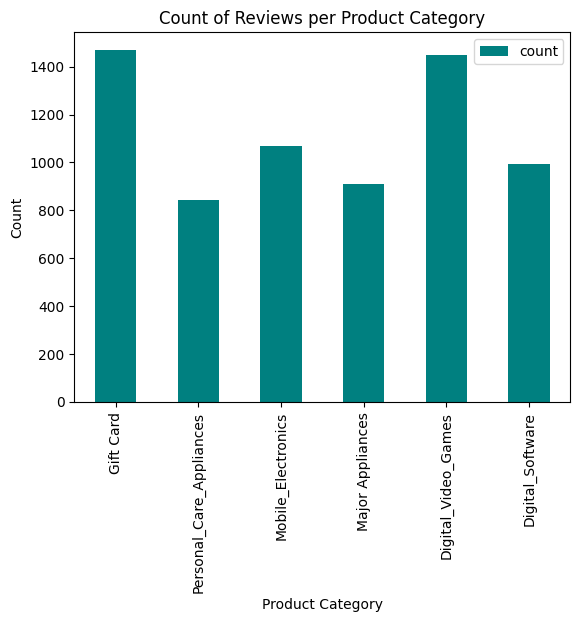

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

pdf = df.toPandas()
pdf_reviews_per_category = df.groupBy("product_category").count().toPandas()

plt.figure(figsize=(12, 6))
pdf_reviews_per_category.plot(kind='bar', x='product_category', y='count', color='teal')
plt.title('Count of Reviews per Product Category')
plt.xlabel('Product Category')
plt.ylabel('Count')
#plt.xticks(rotation=45)
plt.show()

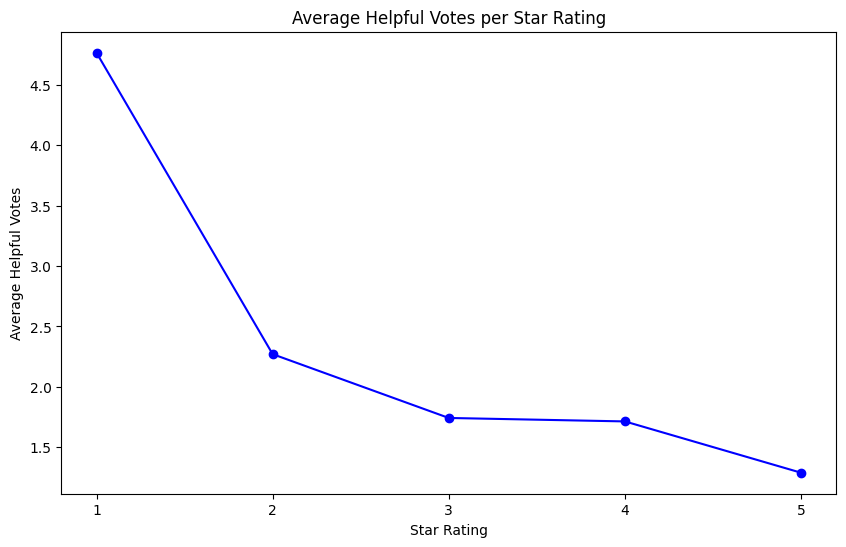

In [8]:
pdf_avg_helpful_votes_per_rating = df.groupBy("star_rating")\
                                     .agg(mean(col("helpful_votes")))\
                                     .orderBy("star_rating")\
                                     .toPandas()

plt.figure(figsize=(10, 6))
plt.plot(pdf_avg_helpful_votes_per_rating['star_rating'], pdf_avg_helpful_votes_per_rating['avg(helpful_votes)'], marker='o', color='blue')
plt.title('Average Helpful Votes per Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Average Helpful Votes')
plt.xticks(range(1, 6))
plt.show()

In [9]:
from pyspark.sql.functions import sum as _sum

df_with_helpful_flag = df.withColumn("is_helpful", (col("helpful_votes") > 0).cast("integer"))

helpful_percentage_per_rating = df_with_helpful_flag.groupBy("star_rating").agg(
    (_sum("is_helpful") / count("*") * 100).alias("helpful_percentage")
).orderBy("star_rating")

helpful_percentage_per_rating.show()

+-----------+------------------+
|star_rating|helpful_percentage|
+-----------+------------------+
|          1|         55.078125|
|          2|44.668587896253605|
|          3| 36.05577689243028|
|          4| 33.77777777777778|
|          5|20.671378091872793|
+-----------+------------------+



<Figure size 1000x600 with 0 Axes>

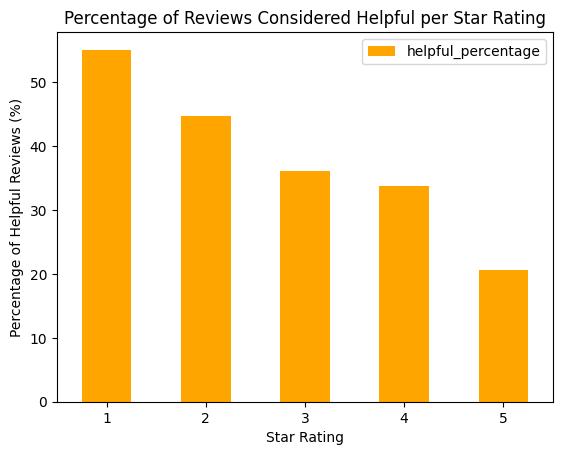

In [10]:
pdf_helpful_percentage = helpful_percentage_per_rating.toPandas()

plt.figure(figsize=(10, 6))
pdf_helpful_percentage.plot(kind='bar', x='star_rating', y='helpful_percentage', color='orange')
plt.title('Percentage of Reviews Considered Helpful per Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Percentage of Helpful Reviews (%)')
plt.xticks(rotation=0)
plt.show()

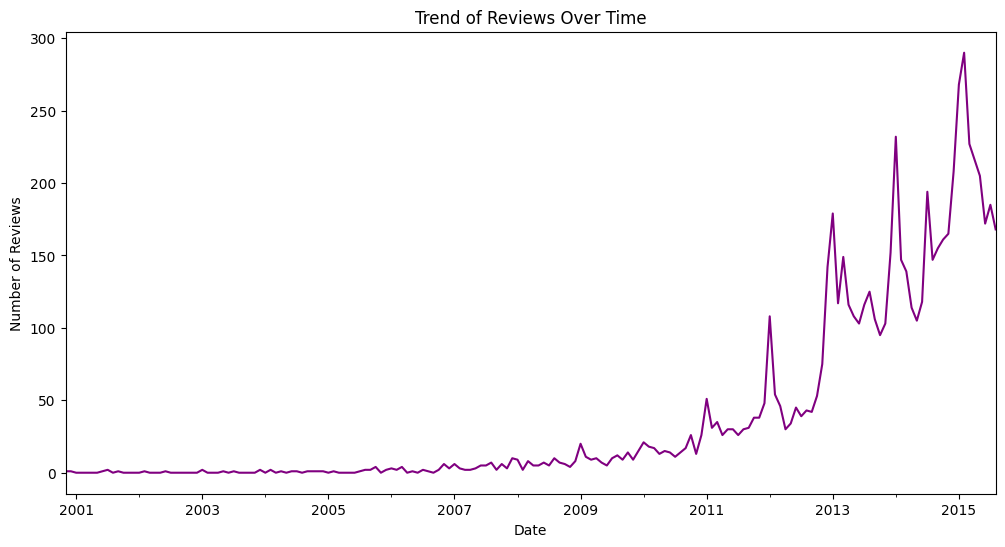

In [11]:
pdf['review_date'] = pd.to_datetime(pdf['review_date'], errors='coerce', format='%Y-%m-%d')

# Drop rows where review_date is NaT (Not a Time) due to conversion errors
pdf = pdf.dropna(subset=['review_date'])

pdf.set_index('review_date', inplace=True)

monthly_reviews = pdf.resample('M').size()

plt.figure(figsize=(12, 6))
monthly_reviews.plot(color='purple')
plt.title('Trend of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

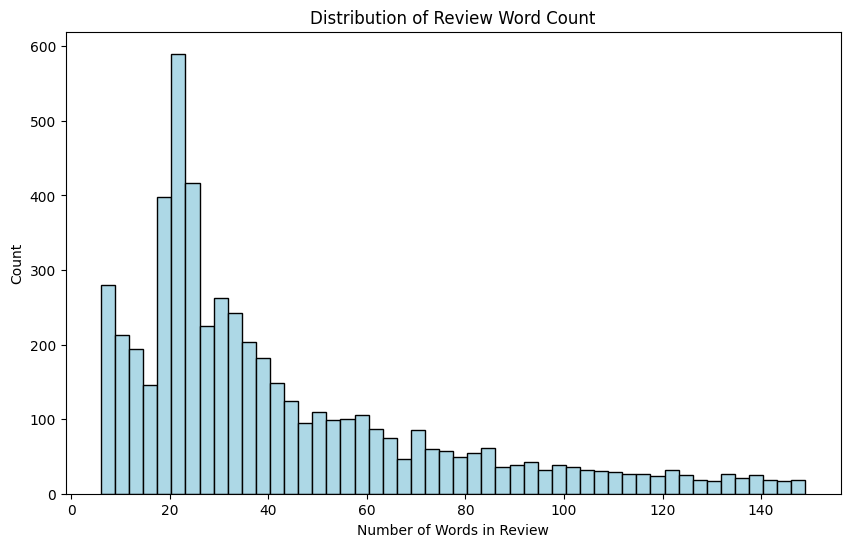

In [12]:
pdf['review_word_count'] = pdf['review_body'].str.split().apply(lambda x: len(x) if x is not None else 0)

filtered_pdf = pdf[(pdf['review_word_count'] > 5) & (pdf['review_word_count'] < 150)]

plt.figure(figsize=(10, 6))
plt.hist(filtered_pdf['review_word_count'], bins=50, color='lightblue', edgecolor='black')
plt.title('Distribution of Review Word Count')
plt.xlabel('Number of Words in Review')
plt.ylabel('Count')

plt.show()

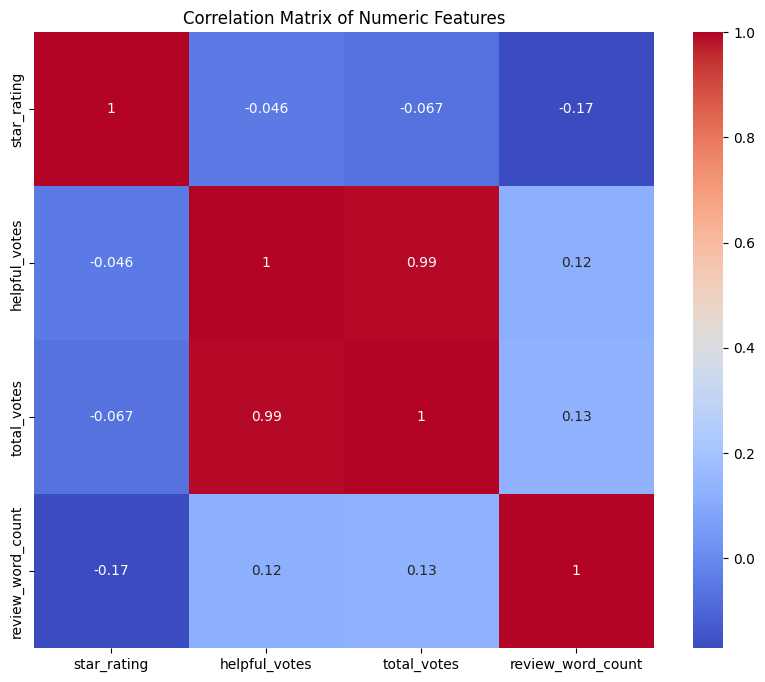

In [13]:
import seaborn as sns

corr_matrix = pdf[['star_rating', 'helpful_votes', 'total_votes', 'review_word_count']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

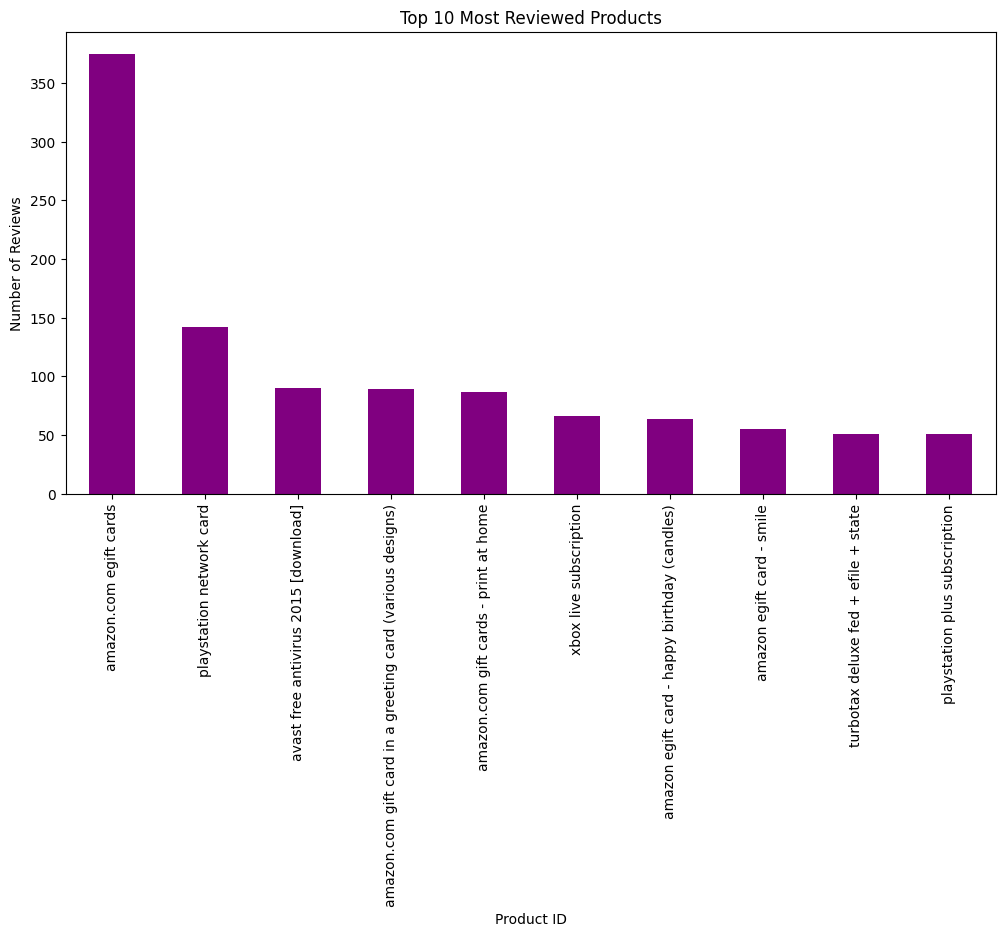

In [14]:
reviews_per_product = pdf['product_title'].value_counts().head(10)

plt.figure(figsize=(12, 6))
reviews_per_product.plot(kind='bar', color='purple')
plt.title('Top 10 Most Reviewed Products')
plt.xlabel('Product ID')
plt.ylabel('Number of Reviews')
plt.show()

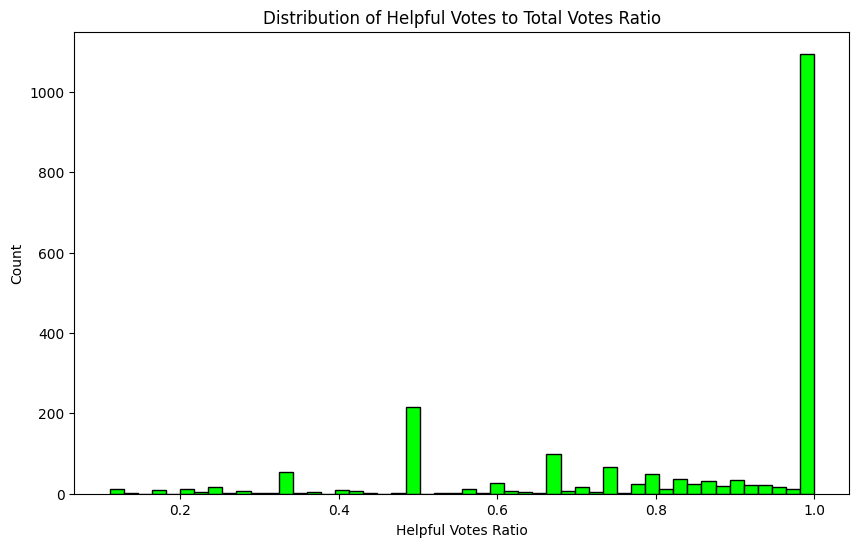

In [15]:
pdf['helpful_ratio'] = pdf['helpful_votes'] / pdf['total_votes']
pdf['helpful_ratio'] = pdf['helpful_ratio'].fillna(0)

pdf_filtered = pdf[pdf['helpful_ratio'] > 0.1]
plt.figure(figsize=(10, 6))
plt.hist(pdf_filtered['helpful_ratio'], bins=50, color='lime', edgecolor='black')
plt.title('Distribution of Helpful Votes to Total Votes Ratio')
plt.xlabel('Helpful Votes Ratio')
plt.ylabel('Count')
plt.show()

In [16]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_sentiment_compound(text):
    if pd.isna(text):
        return None
    return sia.polarity_scores(text)['compound']

def get_sentiment_neutral(text):
    if pd.isna(text):
        return None
    return sia.polarity_scores(text)['neu']

pdf['sentiment_score'] = pdf['review_body'].apply(get_sentiment_compound)
pdf['neutral_score'] = pdf['review_body'].apply(get_sentiment_neutral)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mihnea\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


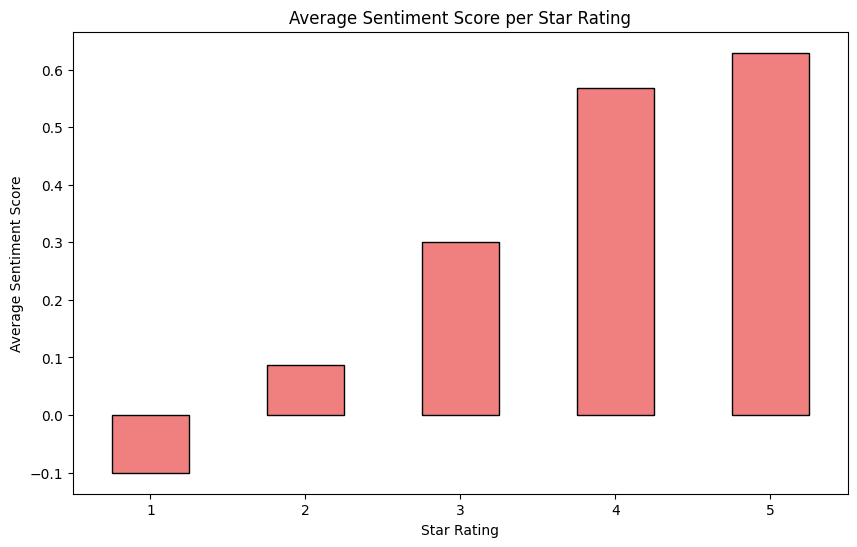

In [17]:
avg_sentiment_per_rating = pdf.groupby('star_rating')['sentiment_score'].mean()

plt.figure(figsize=(10, 6))
avg_sentiment_per_rating.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Average Sentiment Score per Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=0) 
plt.show()

C:\Users\Mihnea\AppData\Local\Temp\ipykernel_24100\673851844.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data_sentiment = pdf.groupby(['star_rating', 'sentiment_category']).agg({'sentiment_score': 'mean'}).reset_index()


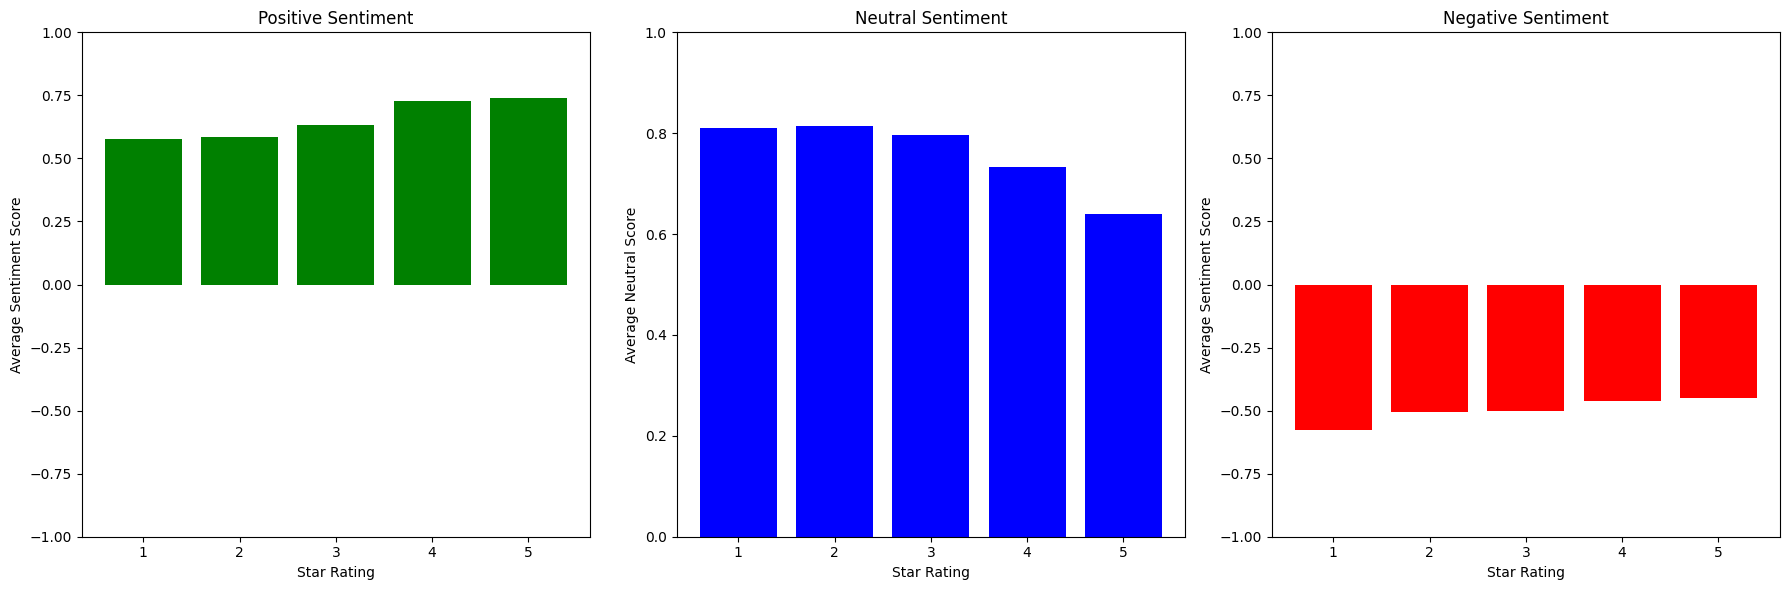

In [18]:
pdf['sentiment_category'] = pd.cut(pdf['sentiment_score'], bins=[-1, -0.05, 0.05, 1], labels=['Negative', 'Neutral', 'Positive'])

grouped_data_sentiment = pdf.groupby(['star_rating', 'sentiment_category']).agg({'sentiment_score': 'mean'}).reset_index()

grouped_data_neutral = pdf.groupby('star_rating').agg({'neutral_score': 'mean'}).reset_index()

positive_data = grouped_data_sentiment[grouped_data_sentiment['sentiment_category'] == 'Positive']
negative_data = grouped_data_sentiment[grouped_data_sentiment['sentiment_category'] == 'Negative']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

axes[0].bar(positive_data['star_rating'], positive_data['sentiment_score'], color='green')
axes[0].set_title('Positive Sentiment')
axes[0].set_xlabel('Star Rating')
axes[0].set_ylabel('Average Sentiment Score')
axes[0].set_ylim([-1, 1])

axes[1].bar(grouped_data_neutral['star_rating'], grouped_data_neutral['neutral_score'], color='blue')
axes[1].set_title('Neutral Sentiment')
axes[1].set_xlabel('Star Rating')
axes[1].set_ylabel('Average Neutral Score')
axes[1].set_ylim([0, 1])

#TODO: possibly reduce y axis values for negative plot
axes[2].bar(negative_data['star_rating'], negative_data['sentiment_score'], color='red')
axes[2].set_title('Negative Sentiment')
axes[2].set_xlabel('Star Rating')
axes[2].set_ylabel('Average Sentiment Score')
axes[2].set_ylim([-1, 1])

plt.tight_layout()
plt.show()

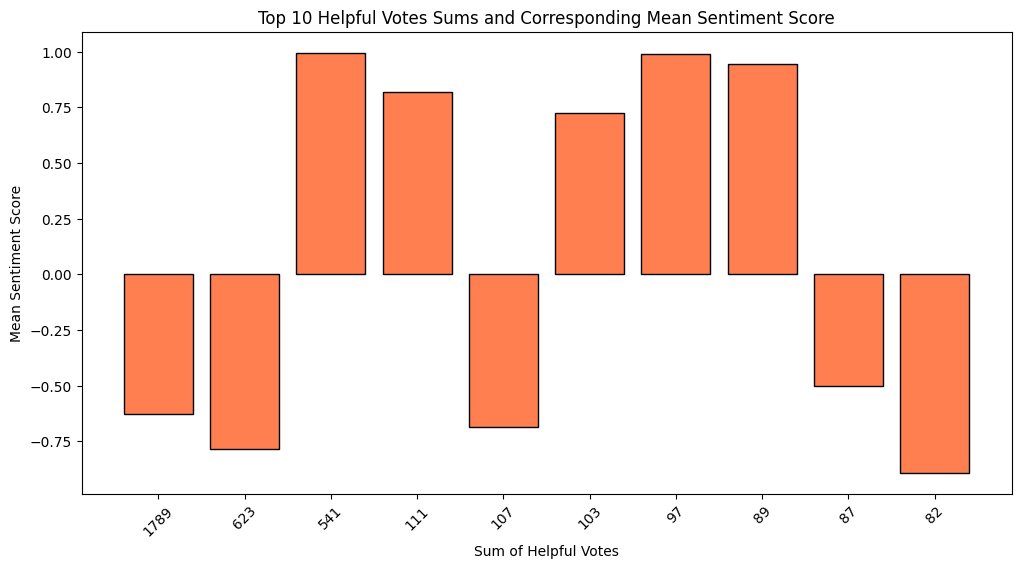

In [19]:
customer_helpful_votes = pdf.groupby('customer_id').agg({'helpful_votes': 'sum', 'sentiment_score': 'mean'})

top_customers = customer_helpful_votes.sort_values(by='helpful_votes', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_customers['helpful_votes'].astype(str), top_customers['sentiment_score'], color='coral', edgecolor='black')
plt.title('Top 10 Helpful Votes Sums and Corresponding Mean Sentiment Score')
plt.xlabel('Sum of Helpful Votes')
plt.ylabel('Mean Sentiment Score')
plt.xticks(rotation=45)
plt.show()

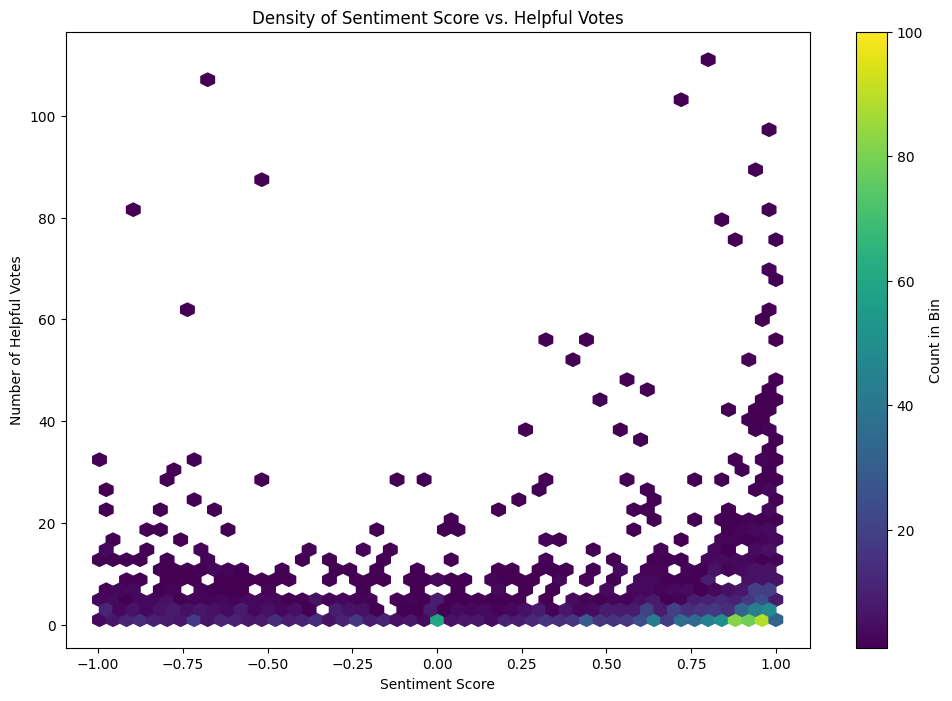

In [20]:
median_sentiment = pdf['sentiment_score'].median()
std_dev_sentiment = pdf['sentiment_score'].std()
median_helpful_votes = pdf['helpful_votes'].median()
std_dev_helpful_votes = pdf['helpful_votes'].std()

filtered_pdf = pdf[(pdf['helpful_votes'] >= 1) & (pdf['helpful_votes'] <= 500)]

plt.figure(figsize=(12, 8))
plt.hexbin(filtered_pdf['sentiment_score'], filtered_pdf['helpful_votes'], gridsize=50, cmap='viridis', mincnt=1,vmax=100)
plt.colorbar(label='Count in Bin')
plt.title('Density of Sentiment Score vs. Helpful Votes')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Helpful Votes')
plt.show()

In [44]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer

df = spark.createDataFrame(pdf)

string_indexer = StringIndexer(inputCol="product_id", outputCol="product_id_indexed")
df_indexed = string_indexer.fit(df).transform(df)

(train, test) = df_indexed.randomSplit([0.8, 0.2], seed=12345)

als = ALS(maxIter=5, regParam=0.01, userCol="customer_id", itemCol="product_id_indexed", ratingCol="star_rating", coldStartStrategy="drop", nonnegative=True)
model = als.fit(train)

predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="star_rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

user_recommendations = model.recommendForAllUsers(10)

user_recommendations.show(5, truncate=False)

c:\Users\Mihnea\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\pandas\conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


Root-mean-square error = 2.1958673000335693
+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|customer_id|recommendations                                                                                                                                                                           |
+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|139473     |[{204, 1.2214159}, {335, 1.1411899}, {2237, 1.0833533}, {2117, 1.0332104}, {639, 1.0139003}, {364, 0.9998921}, {276, 0.96139514}, {1432, 0.9602407}, {2401, 0.9543106}, {2383, 0.9207659}]|
|217601     |[{2135, 8.334124}, {2480, 7.678494}, {1962, 7.468669}, {1281, 7.1876326}, {802, 6.989462}, {1512, 6.664549}, {796, 6.6147814}, {979, 6.5981

In [54]:
from pyspark.sql.functions import col, explode

user_id_row = user_recommendations.select('customer_id').first()
user_id = user_id = user_id_row['customer_id']

user_recs = user_recommendations.filter(user_recommendations['customer_id'] == user_id)

exploded_recommendations = user_recs.select('customer_id', explode('recommendations').alias('recommendation'))
recommended_product_ids = exploded_recommendations.select('customer_id','recommendation.product_id_indexed')

distinct_products = df_indexed.select('product_id_indexed', 'product_title').distinct()

recommended_product_details = recommended_product_ids.join(distinct_products, 'product_id_indexed').select('customer_id', 'product_id_indexed', 'product_title')

final_recommendations = recommended_product_details.filter(recommended_product_details['customer_id'] == user_id)

final_recommendations.show()

+-----------+------------------+--------------------+
|customer_id|product_id_indexed|       product_title|
+-----------+------------------+--------------------+
|     139473|              2237|numark cdn77usb d...|
|     139473|              1432|(many colors avai...|
|     139473|              2383|replay xd 1080 co...|
|     139473|               364|  all-in-one mahjong|
|     139473|               204|power one size 31...|
|     139473|               639|grand theft auto ...|
|     139473|              2117|frigidaire ffec32...|
|     139473|               335|amazon egift card...|
|     139473|               276|the sims 3 late n...|
|     139473|              2401|brand new kenwood...|
+-----------+------------------+--------------------+



In [57]:
highly_rated_products_by_user = df_indexed.filter((df_indexed['customer_id'] == user_id) & (df_indexed['star_rating'] >= 3))

distinct_highly_rated_products = highly_rated_products_by_user.select('product_id_indexed', 'product_title', 'star_rating').distinct()

distinct_highly_rated_products.show()

+------------------+-------------+-----------+
|product_id_indexed|product_title|star_rating|
+------------------+-------------+-----------+
+------------------+-------------+-----------+



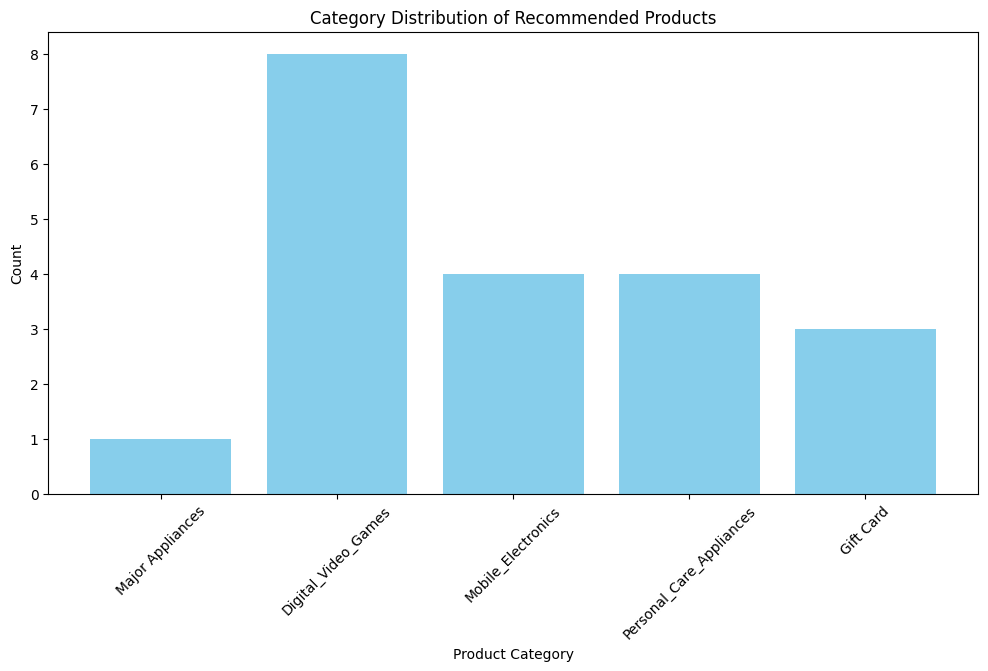

In [60]:
recommended_product_ids = recommended_product_details.select('product_id_indexed')

recommended_with_category = recommended_product_ids.join(df_indexed, 'product_id_indexed').select('product_id_indexed', 'product_category')

category_counts = recommended_with_category.groupBy('product_category').count().toPandas()

plt.figure(figsize=(12, 6))
plt.bar(category_counts['product_category'], category_counts['count'], color='skyblue')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.title('Category Distribution of Recommended Products')
plt.xticks(rotation=45)
plt.show()